# Image matching dataset
- Download the dataset from Kaggle competition page: [Image Matching Challenge 2025](https://www.kaggle.com/competitions/image-matching-challenge-2025/data)
- Custom Dataset class to load the dataset
- Normalize the images with mean and std of 0.5 for all channels.

In [1]:
from data_preprocess.image_matching_dataset import ImageMatchingDataset
import torchvision.transforms as transforms
import torch
from torchvision.transforms.functional import pad

class PadToSize():
    def __init__(self, size, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        w, h = img.size
        pad_h = max(0, self.size - h)
        pad_w = max(0, self.size - w)
        padding = [pad_w//2, pad_h//2, pad_w - pad_w//2, pad_h - pad_h//2]
        return pad(img, padding, fill=self.fill)

        
'''Original dataset, no resizing performed, does not work with dataloader since it requires all images of same dimensions'''
train_dataset = ImageMatchingDataset(labels_path='data/train_labels.csv', root_dir='data/train',
                               transform=transforms.Compose([
                                   transforms.ToTensor()
                               ]))

'''train_dataset_resize = ImageMatchingDataset(labels_path='data/train_labels.csv', root_dir='data/train',
                               transform=transforms.Compose([
                                   transforms.Resize((1024, 1024)),
                                   transforms.Pad((0, 0, 1024, 1024), fill=0),
                                   transforms.ToTensor()
                               ]))'''


'''Dataset with resizing and padding if needed, to be used with dataloader to work in batches'''
train_dataset_eq_size = ImageMatchingDataset(labels_path='data/train_labels.csv', root_dir='data/train',
                               transform=transforms.Compose([
                                   PadToSize(1024, fill=0),
                                   transforms.Resize((1024, 1024), antialias=True),
                                   transforms.ToTensor()
                               ]))

## Initial Analysis of the dataset

## Creating descriptors for the dataset and saving them

'Total images in the training label csv:'

1945

'Total length of the dataset:'

1945

<Axes: title={'center': 'Scene distribution'}, xlabel='scene'>

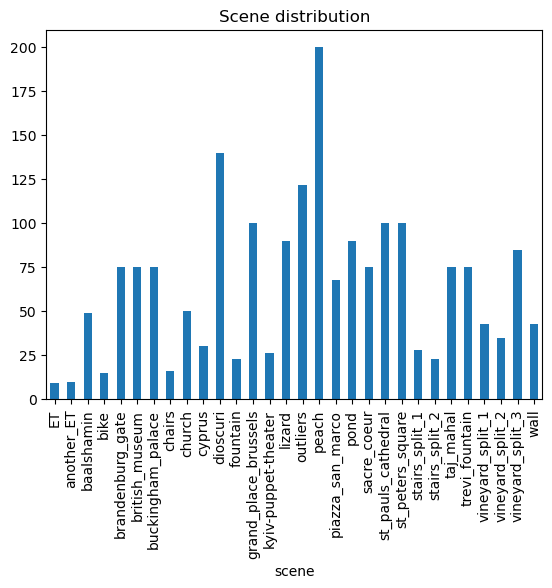

In [24]:
import pandas as pd

labels = pd.read_csv('data/train_labels.csv')
display('Total images in the training label csv:',labels.count().dataset)
display('Total length of the dataset:',train_dataset.__len__())

labels.groupby('scene').count().dataset.plot(kind='bar', title="Scene distribution")

In [63]:
display('Total outliers in the dataset',labels.groupby('scene').get_group('outliers').count().dataset)

'Total outliers in the dataset'

122

<Axes: title={'center': 'Outliers in each dataset'}, xlabel='dataset'>

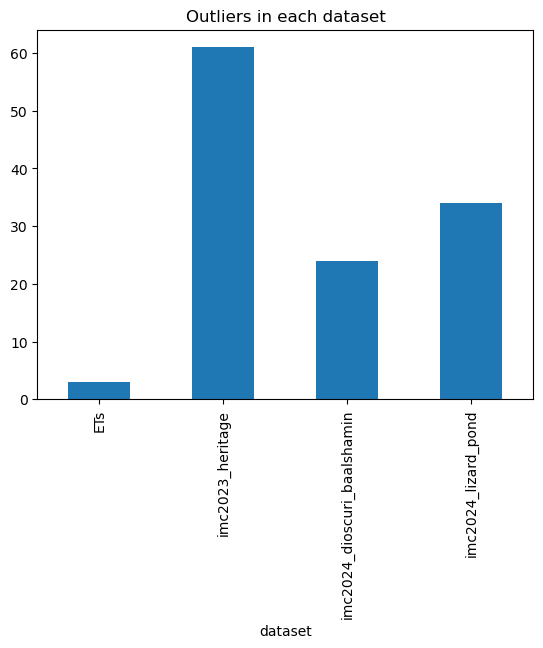

In [95]:
labels[labels['scene']=='outliers'].groupby('dataset').size().plot(kind='bar',title='Outliers in each dataset')

In [107]:
#labels.groupby(['dataset','scene']).count()
# Combination of each dataset and scene and total images for each

In [105]:
display(labels.groupby('dataset')['scene'].nunique())
display('Number of scenes per dataset')

dataset
ETs                                  3
amy_gardens                          1
fbk_vineyard                         3
imc2023_haiper                       3
imc2023_heritage                     4
imc2023_theather_imc2024_church      2
imc2024_dioscuri_baalshamin          3
imc2024_lizard_pond                  3
pt_brandenburg_british_buckingham    3
pt_piazzasanmarco_grandplace         2
pt_sacrecoeur_trevi_tajmahal         3
pt_stpeters_stpauls                  2
stairs                               2
Name: scene, dtype: int64

'Number of scenes per dataset'

# Dataset loading using dataloader and running each combination of descriptor + matcher

In [2]:
from torch.utils.data import DataLoader

DEVICE = torch.device(0 if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset_eq_size, batch_size=8, shuffle=True, num_workers=4,pin_memory=True)

#train_features = next(iter(train_loader))
#print(f'Keys of the batch: {train_features.keys()}')
#print(f"Feature batch shape: {train_features['image'].size()}")
#print(f"Labels size: {labels.size}")


In [4]:
''' Pseudo dataset containing descriptor pairs of each image so that we do not have to care about batching for each dataset.
Assuming descriptors saved in folders, where each file contains dataset name, image name and descriptor and key points.
Pseudo dataset will contain all the information(keys or columns of original dataset) for both the images image1 and image2.
Also, assuming the SIFT and DISK returns 'keypoints', 'keypoint_scores', 'descriptors', 'image_size' for each image.
'''

" Pseudo dataset containing descriptor pairs of each image so that we do not have to care about batching for each dataset.\nAssuming descriptors saved in folders, where each file contains dataset name, image name and descriptor and key points.\nPseudo dataset will contain all the information(keys or columns of original dataset) for both the images image1 and image2.\nAlso, assuming the SIFT and DISK returns 'keypoints', 'keypoint_scores', 'descriptors', 'image_size' for each image.\n"

In [3]:
from feature_matching.lightglue_matcher import get_SIFT_features, get_DISK_features, match_features
import os, h5py

import kornia

def save_result(save_dir,extractor,i,image, image_size, dataset_name, scene_name,image_name, image_path, res):
    os.makedirs(save_dir, exist_ok=True)
    out_path = os.path.join(save_dir, f"{i}_1024_{extractor}.h5")
    dt = h5py.string_dtype(encoding="utf-8")
    with h5py.File(out_path, 'w') as f:
        f.create_dataset('keypoints', data=res['keypoints'].cpu().detach().numpy())
        f.create_dataset('keypoint_scores', data=res['keypoint_scores'].cpu().detach().numpy())
        f.create_dataset('descriptors', data=res['descriptors'].cpu().detach().numpy())
        f.create_dataset('keypoints_mask', data=res['keypoints_mask'].cpu().detach().numpy())
        f.create_dataset('image', data=image.cpu().detach().numpy())
        f.create_dataset('image_size', data=image_size.cpu().detach().numpy())
        f.create_dataset('image_name', data=image_name, dtype=dt)
        f.create_dataset('dataset_name', data=dataset_name, dtype=dt)
        f.create_dataset('scene_name', data=scene_name, dtype=dt)
        f.create_dataset('image_path', data=image_path, dtype=dt)




for i,batch in enumerate(train_loader):
    torch.cuda.empty_cache()
    features = get_DISK_features(batch['image'].to(DEVICE), device = DEVICE)
    save_result('evaluation/disk_descriptors_outputs/','disk',i,batch['image'], batch['image_size'],batch['dataset_name'], batch['scene_name'],batch['image_name'],batch['image_path'],features)
    del features
    

In [ ]:
import h5py
import numpy as np
from pathlib import Path
'''To check if there are any zeros/false in mask for identifying the images which have been padded'''
root = Path("evaluation/disk_descriptors_outputs")

for h5_path in sorted(root.glob("*.h5")):
    print(f"\n=== {h5_path.name} ===")
    with h5py.File(h5_path, "r") as f:
        # Optional: show structure
        # f.visititems(print_h5_structure)

        if "keypoints_mask" not in f:
            print("keypoints_mask not found")
            continue

        mask = f["keypoints_mask"][:]  # shape (B, Nmax) typically
        zeros = np.where(mask == 0)
        total_zeros = zeros[0].size
        print(f"total zeros: {total_zeros}")

        # If you want the exact indices (batch_idx, kp_idx), print a small sample:
        if total_zeros > 0:
            sample = list(zip(zeros[0], zeros[1]))[:50]
            print(f"indices sample (up to 50): {sample}")

In [4]:
import h5py
import numpy as np
from pathlib import Path
import glob

root = Path("evaluation/disk_descriptors_outputs")
file_gen = root.glob("[0-9]*.h5")

if not file_gen:
    raise ValueError("No .h5 files found in the folder.")

first_file = next(file_gen)
with h5py.File(first_file, "r") as f:
    keys = list(f.keys())


with h5py.File(root / "merged.h5", "w") as fout:

    for key in keys:
        # Determine the dtype and initial shape from first file
        with h5py.File(first_file, "r") as f:
            data = f[key][...]
        fout.create_dataset(key, data=data, maxshape=(None,) + data.shape[1:])

    #iterate over the remaining files
    for filepath in file_gen:  
        with h5py.File(filepath, "r") as f:
            for key in keys:
                old_data = fout[key]
                new_data = f[key][...]
                old_len = old_data.shape[0]
                new_len = new_data.shape[0]
                old_data.resize(old_len + new_len, axis=0)
                old_data[old_len:] = new_data


In [2]:
import h5py
import numpy as np
def print_h5_structure(name, obj):
    print(name)

with h5py.File("evaluation/matches_output/disk_lightglue_matches/10_lightglue_disk.h5", "r") as f:
    for key in f.keys():
        num_rows = f[key]
        print(f"{key}: {num_rows} rows")

0: <HDF5 group "/0" (7 members)> rows
1: <HDF5 group "/1" (7 members)> rows
10: <HDF5 group "/10" (7 members)> rows
11: <HDF5 group "/11" (7 members)> rows
12: <HDF5 group "/12" (7 members)> rows
13: <HDF5 group "/13" (7 members)> rows
14: <HDF5 group "/14" (7 members)> rows
15: <HDF5 group "/15" (7 members)> rows
16: <HDF5 group "/16" (7 members)> rows
17: <HDF5 group "/17" (7 members)> rows
18: <HDF5 group "/18" (7 members)> rows
19: <HDF5 group "/19" (7 members)> rows
2: <HDF5 group "/2" (7 members)> rows
20: <HDF5 group "/20" (7 members)> rows
21: <HDF5 group "/21" (7 members)> rows
22: <HDF5 group "/22" (7 members)> rows
23: <HDF5 group "/23" (7 members)> rows
24: <HDF5 group "/24" (7 members)> rows
25: <HDF5 group "/25" (7 members)> rows
26: <HDF5 group "/26" (7 members)> rows
27: <HDF5 group "/27" (7 members)> rows
28: <HDF5 group "/28" (7 members)> rows
29: <HDF5 group "/29" (7 members)> rows
3: <HDF5 group "/3" (7 members)> rows
30: <HDF5 group "/30" (7 members)> rows
31: <HDF

In [11]:
from data_preprocess.image_pair_csv_dataset import ImagePairCsv
import pandas as pd

image_pair_csv = ImagePairCsv(labels_path='data/train_labels.csv', output_dir='data/train_pairs')

pairs_csv = pd.read_csv('data/train_pairs/data_pairs.csv')
print(pairs_csv.count()/48)

image1     3691.625
image2     3691.625
dataset    3691.625
dtype: float64


In [2]:
from data_preprocess.pseudo_dataset_matching import PseudoMatchingDataset
from torch.utils.data import DataLoader
import torch

DEVICE = torch.device(0 if torch.cuda.is_available() else 'cpu')
print(DEVICE)
pseudo_matching_dataset = PseudoMatchingDataset(pairs_path='data/train_pairs/data_pairs.csv', descriptors_path='evaluation/disk_descriptors_outputs/merged.h5', descriptor_type='disk', device=DEVICE )

train_loader = DataLoader(pseudo_matching_dataset, batch_size=48, num_workers= 8, shuffle=False)

#train_features = next(iter(train_loader))
#print(f'Keys of the batch: {train_features.keys()}')
#print(f"Feature batch shape: {train_features['features1']}")

cuda:0


In [ ]:
import h5py
from pathlib import Path
from feature_matching.lightglue_matcher import match_features_for_plots
import cv2 as cv
import numpy as np
from batch_matcher import process_batches
import os

# Set up output path
output_dir = Path('evaluation/matches_output/')

# Initialize output files for both matchers
lightglue_output = os.path.join(output_dir,'disk_lightglue_matches' )
output_dir.parent.mkdir(exist_ok=True, parents=True)

flann_output = output_dir / 'disk_flann_matches'
print(lightglue_output)

# Run both matchers
print("Running LightGlue matching...")
lightglue_matches = process_batches(
    train_loader,
    output_path=lightglue_output,
    device = DEVICE
)

'''print("\nRunning FLANN matching...")
flann_matches = process_batches(
    train_loader,
    matcher='flann',
    output_path=flann_output
)
'''
print("\nMatching complete!")
print(f"LightGlue matches saved to: {lightglue_output}")


evaluation/matches_output/disk_lightglue_matches
Running LightGlue matching...
Processing 3692 batches...


Matches for the loader:  46%|████▋     | 1715/3692 [2:35:37<2:59:27,  5.45s/batch]

In [1]:
from load_h5py_files import load_matches_from_h5
from pathlib import Path
import os

output_dir = Path('evaluation/matches_output/')

# Initialize output files for both matchers
lightglue_output = os.path.join(output_dir,'disk_lightglue_matches' )
load_matches_from_h5(lightglue_output+ "/12_lightglue_disk.h5")

<HDF5 group "/0" (7 members)>
<HDF5 group "/1" (7 members)>
<HDF5 group "/10" (7 members)>
<HDF5 group "/11" (7 members)>
<HDF5 group "/12" (7 members)>
<HDF5 group "/13" (7 members)>
<HDF5 group "/14" (7 members)>
<HDF5 group "/15" (7 members)>
<HDF5 group "/16" (7 members)>
<HDF5 group "/17" (7 members)>
<HDF5 group "/18" (7 members)>
<HDF5 group "/19" (7 members)>
<HDF5 group "/2" (7 members)>
<HDF5 group "/20" (7 members)>
<HDF5 group "/21" (7 members)>
<HDF5 group "/22" (7 members)>
<HDF5 group "/23" (7 members)>
<HDF5 group "/24" (7 members)>
<HDF5 group "/25" (7 members)>
<HDF5 group "/26" (7 members)>
<HDF5 group "/27" (7 members)>
<HDF5 group "/28" (7 members)>
<HDF5 group "/29" (7 members)>
<HDF5 group "/3" (7 members)>
<HDF5 group "/30" (7 members)>
<HDF5 group "/31" (7 members)>
<HDF5 group "/32" (7 members)>
<HDF5 group "/33" (7 members)>
<HDF5 group "/34" (7 members)>
<HDF5 group "/35" (7 members)>
<HDF5 group "/36" (7 members)>
<HDF5 group "/37" (7 members)>
<HDF5 group 

[{'image1': 'piazza_san_marco_19489590_236391387.png',
  'image2': 'grand_place_brussels_45351744_6834302276.png',
  'dataset': 'pt_piazzasanmarco_grandplace',
  'points0': tensor([[227., 161.],
          [589., 237.],
          [588., 251.],
          [590., 264.],
          [584., 298.],
          [130., 304.],
          [135., 305.],
          [145., 308.],
          [158., 312.],
          [173., 317.],
          [611., 317.],
          [579., 332.],
          [343., 336.],
          [353., 339.],
          [671., 340.],
          [615., 362.],
          [683., 363.],
          [727., 365.],
          [663., 368.],
          [343., 369.],
          [622., 370.],
          [715., 370.],
          [126., 376.],
          [602., 377.],
          [630., 386.],
          [673., 386.],
          [663., 387.],
          [667., 387.],
          [502., 389.],
          [609., 397.],
          [629., 397.],
          [707., 400.],
          [607., 403.],
          [790., 424.],
          [60

In [2]:
from data_preprocess.matcher_csv import MatcherCsv

#MatcherCsv("lightglue", "sift", flann_sift_output, "csv_matcher")
MatcherCsv("lightglue", "disk", lightglue_output, "csv_matcher")

<HDF5 group "/0" (7 members)>
<HDF5 group "/1" (7 members)>
<HDF5 group "/10" (7 members)>
<HDF5 group "/11" (7 members)>
<HDF5 group "/12" (7 members)>
<HDF5 group "/13" (7 members)>
<HDF5 group "/14" (7 members)>
<HDF5 group "/15" (7 members)>
<HDF5 group "/16" (7 members)>
<HDF5 group "/17" (7 members)>
<HDF5 group "/18" (7 members)>
<HDF5 group "/19" (7 members)>
<HDF5 group "/2" (7 members)>
<HDF5 group "/20" (7 members)>
<HDF5 group "/21" (7 members)>
<HDF5 group "/22" (7 members)>
<HDF5 group "/23" (7 members)>
<HDF5 group "/24" (7 members)>
<HDF5 group "/25" (7 members)>
<HDF5 group "/26" (7 members)>
<HDF5 group "/27" (7 members)>
<HDF5 group "/28" (7 members)>
<HDF5 group "/29" (7 members)>
<HDF5 group "/3" (7 members)>
<HDF5 group "/30" (7 members)>
<HDF5 group "/31" (7 members)>
<HDF5 group "/32" (7 members)>
<HDF5 group "/33" (7 members)>
<HDF5 group "/34" (7 members)>
<HDF5 group "/35" (7 members)>
<HDF5 group "/36" (7 members)>
<HDF5 group "/37" (7 members)>
<HDF5 group 

In [5]:
import pandas as pd
df_flann_sift = pd.read_csv("csv_matcher/result_lightglue_disk.csv")
df_flann_sift['features1']

0               {'scene': 'fountain'}
1               {'scene': 'fountain'}
2               {'scene': 'fountain'}
3               {'scene': 'fountain'}
4               {'scene': 'fountain'}
                     ...             
177193    {'scene': 'stairs_split_2'}
177194    {'scene': 'stairs_split_2'}
177195    {'scene': 'stairs_split_2'}
177196    {'scene': 'stairs_split_2'}
177197    {'scene': 'stairs_split_2'}
Name: features1, Length: 177198, dtype: object

In [17]:
from data_preprocess.image_matching_dataset import ImageMatchingDataset
import torchvision.transforms as transforms
import torch

from load_h5py_files import load_sift_output, load_flann_output, load_flann_from_images_name
from clustering.cluster_images import build_graph, graph_clustering, interactive_graph
from batch_descriptor import batch_feature_descriptor
from torch.utils.data import DataLoader

import os
import cv2 as cv
import h5py
import numpy as np
import pandas as pd
import ast
import json

from clustering.ransac_test import run_ransac
from load_h5py_files import load_matches_from_h5
import networkx as nx

def clustering_with_ransac(matches_file, labels_df, matcher_type, descriptor_type):
    '''
    Args:
        matches_file (str): path to CSV image matching result
        labels_df (DataFrame): dataframe of train labels CSV
        matcher_type (str): matcher type (flann / lightglue)
        descriptor_type (str): descriptor type (sift / disk)

    Returns:
        Dict: Dictionary containing dataset and its graph
        Dict: Dictionary containing dataset and its clustering data
    '''
    matches_df = pd.read_csv(matches_file)

    # add new column in dataframe for ransac data
    matches_df["filtered_points0"] = None
    matches_df["filtered_points1"] = None
    matches_df["ransac_mask"] = None

    # run ransac
    for idx, data in matches_df.iterrows():
        points0 = torch.Tensor(ast.literal_eval(data["points0"]))
        points1 = torch.Tensor(ast.literal_eval(data["points1"]))
    
        filtered_p0, filtered_p1, ransac_mask = run_ransac(points0, points1)
        matches_df.at[idx, "filtered_points0"] = filtered_p0
        matches_df.at[idx, "filtered_points1"] = filtered_p0
        matches_df.at[idx, "ransac_mask"] = ransac_mask

    # create graph
    graphs = build_graph(matches_df, labels_df, matcher_type)

    # save graphs
    graph_output_dir = os.path.join("evaluation", "graphs", f"{matcher_type}_with_{descriptor_type}")
    os.makedirs(graph_output_dir, exist_ok=True)

    for graph in graphs:
        data_graph = nx.node_link_data(graphs[graph], edges="edges")
        with open(os.path.join(graph_output_dir, f"graph_{graph}.json"), "w") as f:
            json.dump(data_graph, f)

    # create clustering
    clustering = graph_clustering(graphs)

    # save clustering
    cluster_output_dir = os.path.join("evaluation","clusters")
    os.makedirs(cluster_output_dir, exist_ok=True)
    with open(os.path.join(cluster_output_dir, f"clusters_{matcher_type}_with_{descriptor_type}.json"), "w") as f:
        json.dump(clustering, f)

    return graphs, clustering

In [12]:
lightglue_disk_path = os.path.join("csv_matcher", "result_lightglue_disk.csv")
labels_df = pd.read_csv("data/train_labels.csv")

visualization_dir = os.path.join("evaluation", "cluster_visualization")
os.makedirs(visualization_dir, exist_ok=True)

In [18]:
graph_lightglue_disk, cluster_lightglue_disk = clustering_with_ransac(lightglue_disk_path, labels_df, "lightglue", "disk")

KeyboardInterrupt: 

In [16]:
import h5py

# Open file (read mode)
with h5py.File("evaluation/matches_output/sift_lightglue_matches/0_lightglue_sift.h5", "r") as f:
    # Loop through all groups
    for group_name in f.keys():
        print(f"Group: {group_name}")
        group = f[group_name]
        
        # Loop through datasets in each group
        for dataset_name in group.keys():
            if dataset_name =='points0':
                print(group[dataset_name][:].shape)
            dataset = group[dataset_name][()]
            print(f" {dataset}")
            
            # If you want to actually see the data (be careful if big!)
            # print(dataset[:])

Group: 0
 b'imc2023_haiper'
 b'fountain_image_116.png'
 b'fountain_image_108.png'
(405, 2)
 [[ 196.93474  1001.8745  ]
 [ 845.6485    186.36713 ]
 [ 198.21541   947.64484 ]
 [ 844.17065   220.2713  ]
 [ 193.97597  1011.96387 ]
 [ 839.8142    216.83043 ]
 [ 546.8124    321.95114 ]
 [ 538.1494    546.8765  ]
 [ 835.0858    213.8612  ]
 [ 548.34753   976.1301  ]
 [ 535.5673    979.1065  ]
 [ 550.5353    555.2046  ]
 [ 187.69589  1005.4691  ]
 [ 187.67018   971.93    ]
 [ 825.01324   214.36256 ]
 [ 820.9276    229.15953 ]
 [ 860.89886   199.37259 ]
 [ 183.86288   991.3402  ]
 [ 814.29626   372.4274  ]
 [ 813.04816   219.06636 ]
 [ 556.97784   499.08704 ]
 [ 811.6943    134.17769 ]
 [ 811.0887    209.60646 ]
 [ 809.31866   400.8833  ]
 [ 181.29797   961.5359  ]
 [ 807.5687    221.46588 ]
 [ 806.82324   210.26201 ]
 [ 180.1974    868.3378  ]
 [ 805.1712    205.83923 ]
 [ 804.69507   378.34946 ]
 [ 179.46454   888.4602  ]
 [ 804.28595   416.48206 ]
 [ 804.2       599.3856  ]
 [ 804.06116   10